In [1]:
using LinearAlgebra
using Plots
using DataFrames, CSV, HypothesisTests
using Dates

In [2]:
using Printf
import HTTP
import JSON

export
       # Fred object
       Fred, get_api_url, set_api_url!, get_api_key,

       # FredSeries object
       FredSeries,

       # Download data
       get_data

const MAX_ATTEMPTS       = 3
const FIRST_REALTIME     = Date(1776,07,04)
const LAST_REALTIME      = Date(9999,12,31)
const EARLY_VINTAGE_DATE = "1991-01-01"
const DEFAULT_API_URL    = "https://api.stlouisfed.org/fred/"
const API_KEY_LENGTH     = 32
const KEY_ENV_NAME       = "FRED_API_KEY"
const KEY_FILE_NAME      = ".freddatarc"

# Fred connection type
"""
A connection to the Fred API.
Constructors
------------
- `Fred()`: Key detected automatically. First, looks for the environment variable
    FRED_API_KEY, then looks for the file ~/.freddatarc.
- `Fred(key::AbstractString)`: User specifies key directly
Arguments
---------
- `key`: Registration key provided by the Fred.
Notes
-----
- Set the API url with `set_api_url!(f::Fred, url::AbstractString)`
"""
mutable struct Fred
    key::AbstractString
    url::AbstractString
    function Fred(key, url)
        # Key validation
        if length(key) > API_KEY_LENGTH
            key = key[1:API_KEY_LENGTH]
            warn("FRED API key too long. First $(API_KEY_LENGTH) chars used.")
        elseif length(key) < API_KEY_LENGTH
            error("Invalid FRED API key -- key too short: $(key)")
        end
        if !all(isxdigit, key)
            error("Invalid FRED API key -- invalid characters: $(key)")
        end
        return new(key, url)
    end
end
Fred(key::AbstractString) = Fred(key, DEFAULT_API_URL)
function Fred()
    key = if KEY_ENV_NAME in keys(ENV)
        ENV[KEY_ENV_NAME]
    elseif isfile(joinpath(homedir(), KEY_FILE_NAME))
        open(joinpath(homedir(), KEY_FILE_NAME), "r") do file
            rstrip(read(file, String))
        end
    else
        error("FRED API Key not detected.")
    end

    println("API key loaded.")
    return Fred(key)
end
get_api_key(f::Fred) = f.key
get_api_url(f::Fred) = f.url
set_api_url!(f::Fred, url::AbstractString) = setfield!(f, :url, url)

function Base.show(io::IO, f::Fred)
    @printf io "FRED API Connection\n"
    @printf io "\turl: %s\n" get_api_url(f)
    @printf io "\tkey: %s\n" get_api_key(f)
end


"""
```
FredSeries(...)
```
Represent a single data series, and all associated metadata, as queried from FRED.
The following fields are available:
- `id`
- `title`
- `units_short`
- `units`
- `seas_adj_short`
- `seas_adj`
- `freq_short`
- `freq`
- `realtime_start`
- `realtime_end`
- `last_updated`
- `notes`
- `trans_short`
- `data`
"""
struct FredSeries
    # From series query
    id::AbstractString
    title::AbstractString
    units_short::AbstractString
    units::AbstractString
    seas_adj_short::AbstractString
    seas_adj::AbstractString
    freq_short::AbstractString
    freq::AbstractString
    realtime_start::AbstractString
    realtime_end::AbstractString
    last_updated::DateTime
    notes::AbstractString

    # From series/observations query
    trans_short::AbstractString # "units"
    data::DataFrames.DataFrame

    # deprecated
    df::DataFrames.DataFrame
end

function Base.show(io::IO, s::FredSeries)
    @printf io "FredSeries\n"
    @printf io "\tid: %s\n"                s.id
    @printf io "\ttitle: %s\n"             s.title
    @printf io "\tunits: %s\n"             s.units
    @printf io "\tseas_adj (native): %s\n" s.seas_adj
    @printf io "\tfreq (native): %s\n"     s.freq
    @printf io "\trealtime_start: %s\n"    s.realtime_start
    @printf io "\trealtime_end: %s\n"      s.realtime_end
    @printf io "\tlast_updated: %s\n"      s.last_updated
    @printf io "\tnotes: %s\n"             s.notes
    @printf io "\ttrans_short: %s\n"       s.trans_short
    @printf io "\tdata: %dx%d DataFrame with columns %s\n" size(s.data)... names(s.data)
end

# old, deprecated accessors
export
    id, title, units_short, units, seas_adj_short, seas_adj, freq_short,
    freq, realtime_start, realtime_end, last_updated, notes, trans_short,
    df
@deprecate id(f::FredSeries) getfield(f, :id)
@deprecate title(f::FredSeries) getfield(f, :title)
@deprecate units_short(f::FredSeries) getfield(f, :units_short)
@deprecate units(f::FredSeries) getfield(f, :units)
@deprecate seas_adj_short(f::FredSeries) getfield(f, :seas_adj_short)
@deprecate seas_adj(f::FredSeries) getfield(f, :seas_adj)
@deprecate freq_short(f::FredSeries) getfield(f, :freq_short)
@deprecate freq(f::FredSeries) getfield(f, :freq)
@deprecate realtime_start(f::FredSeries) getfield(f, :realtime_start)
@deprecate realtime_end(f::FredSeries) getfield(f, :realtime_end)
@deprecate last_updated(f::FredSeries) getfield(f, :last_updated)
@deprecate notes(f::FredSeries) getfield(f, :notes)
@deprecate trans_short(f::FredSeries) getfield(f, :trans_short)
@deprecate df(f::FredSeries) getfield(f, :data)

function get_data(f::Fred, series::AbstractString; kwargs...)
    # Validation
    validate_args!(kwargs)

    # Setup
    metadata_url = get_api_url(f) * "series"
    obs_url      = get_api_url(f) * "series/observations"
    api_key      = get_api_key(f)

    # Add query parameters
    metadata_params = Dict("api_key"   => api_key,
                           "file_type" => "json",
                           "series_id" => series)
    obs_params = copy(metadata_params)

    # Query observations. Expand query dict with kwargs. Do this first so we can use the
    # calculated realtime values for the metadata request.
    for (key, value) in kwargs
        obs_params[string(key)] = string(value)
    end
    obs_response = HTTP.request("GET", obs_url, []; query=obs_params)
    obs_json = JSON.parse(String(copy(obs_response.body)))

    # Parse observations
    realtime_start  = obs_json["realtime_start"]
    realtime_end    = obs_json["realtime_end"]
    transformation_short = obs_json["units"]

    df = parse_observations(obs_json["observations"])

    # Query metadata
    metadata_params["realtime_start"] = realtime_start
    metadata_params["realtime_end"] = realtime_end
    metadata_response = HTTP.request("GET", metadata_url, []; query=metadata_params)
    metadata_json = JSON.parse(String(copy(metadata_response.body)))
    # TODO catch StatusError and just return incomplete data to the caller

    # Parse metadata
    metadata_parsed = Dict{Symbol, AbstractString}()
    for k in ["id", "title", "units_short", "units", "seasonal_adjustment_short",
        "seasonal_adjustment", "frequency_short", "frequency", "notes"]
        try
            metadata_parsed[Symbol(k)] = metadata_json["seriess"][1][k]
        catch err
            metadata_parsed[Symbol(k)] = ""
            @warn "Metadata '$k' not returned from server."
        end
    end

    # the last three chars are -05, for CST in St. Louis
    function parse_last_updated(last_updated)
        timezone = last_updated[end-2:end]  # TODO
        return DateTime(last_updated[1:end-3], "yyyy-mm-dd HH:MM:SS")
    end
    last_updated = parse_last_updated(
        metadata_json["seriess"][1]["last_updated"])

    # format notes field
    metadata_parsed[:notes] = strip(replace(replace(
        metadata_parsed[:notes], r"[\r\n]" => " "), r" +" => " "))

    return FredSeries(metadata_parsed[:id], metadata_parsed[:title],
                      metadata_parsed[:units_short], metadata_parsed[:units],
                      metadata_parsed[:seasonal_adjustment_short],
                      metadata_parsed[:seasonal_adjustment],
                      metadata_parsed[:frequency_short], metadata_parsed[:frequency],
                      realtime_start, realtime_end, last_updated, metadata_parsed[:notes],
                      transformation_short, df,
                      df) # deprecated
end

# obs is a vector, of which each element is a dict with four fields,
# - realtime_start
# - realtime_end
# - date
# - value
function parse_observations(obs::Vector)
    n_obs = length(obs)
    value = Vector{Float64}(undef, n_obs)
    date  = Vector{Date}(undef, n_obs)
    realtime_start = Vector{Date}(undef, n_obs)
    realtime_end = Vector{Date}(undef, n_obs)
    for (i, x) in enumerate(obs)
        try
            value[i] = parse(Float64, x["value"])
        catch err
            value[i] = NaN
        end
        date[i]           = Date(x["date"], "yyyy-mm-dd")
        realtime_start[i] = Date(x["realtime_start"], "yyyy-mm-dd")
        realtime_end[i]   = Date(x["realtime_end"], "yyyy-mm-dd")
    end
    return DataFrame(realtime_start=realtime_start, realtime_end=realtime_end,
                     date=date, value=value)
end

isyyyymmdd(x) = occursin(r"^[0-9]{4}-[0-9]{2}-[0-9]{2}$", x)
function validate_args!(kwargs)
    d = Dict(kwargs)

    # dates
    for k in [:realtime_start, :realtime_end, :observation_start, :observation_end]
        if (v = pop!(d, k, nothing)) != nothing && !isyyyymmdd(v)
                error("$k: Invalid date format: $v")
        end
    end
    # limit and offset
    for k in [:limit, :offset]
        if (v = pop!(d, k, nothing)) != nothing &&
            ( !(typeof(v) <: Number ) || typeof(v) <: Number && !(v>0) )
                error("$k: Invalid format: $v")
        end
    end
    # units
    if (v = pop!(d, :units, nothing)) != nothing &&
        v ∉ ["lin", "chg", "ch1", "pch", "pc1", "pca", "cch", "log"]
            error("units: Invalid format: $v")
    end
    # frequency
    if (v = pop!(d, :frequency, nothing)) != nothing &&
        v ∉ ["d", "w", "bw", "m", "q", "sa", "a", "wef", "weth", "wew", "wetu", "wem",
             "wesu", "wesa", "bwew", "bwem"]
            error("frequency: Invalid format: $v")
    end
    # aggregation_method
    if (v = pop!(d, :aggregation_method, nothing)) != nothing &&
        v ∉ ["avg", "sum", "eop"]
            error("aggregation_method: Invalid format: $v")
    end
    # output_type
    if (v = pop!(d, :output_type, nothing)) != nothing &&
        v ∉ [1, 2, 3, 4]
            error("output_type: Invalid format: $v")
    end
    # vintage dates, and too early vintages
    if (v = pop!(d, :vintage_dates, nothing)) != nothing
        vds_arr = split(string(v), ",")
        vds_bad = map(x -> !isyyyymmdd(x), vds_arr)
        if any(vds_bad)
            error("vintage_dates: Invalid date format: $(vds_arr[vds_bad])")
        end
        vds_early = map(x -> x<EARLY_VINTAGE_DATE, vds_arr)
        if any(vds_early)
            warn(:vintage_dates, ": Early vintage date, data might not exist: ",
                vds_arr[vds_early])
        end
    end
    # all remaining keys have unspecified behavior
    if length(d) > 0
        for k in keys(d)
            warn(string(k), ": Bad key. Removed from query.")
            deleteat!(kwargs, findall(x -> x[1]==k, kwargs))
        end
    end
end

validate_args! (generic function with 1 method)

In [3]:
f = Fred("266c597cbf3d25f366b082b4bf5161fe")

FRED API Connection
	url: https://api.stlouisfed.org/fred/
	key: 266c597cbf3d25f366b082b4bf5161fe


In [7]:
### Functions that transform each series to be stationary.
function log_diff(x::DataFrame)
    temp = zeros(length(x[:,1]))
    for i in 1:length(x[:,1])
        temp[i] = log(x[i,2])
    end
    diff_array = diff(temp)
    for i in 1:length(x[:,1])-1
        x[i,2] = diff_array[i]
    end
    x[length(x[:,1]),2] = NaN
    x[:,2] = replace(x[:,2], NaN => missing)
    return x
end

function diff_ts(x::DataFrame)
    temp = zeros(length(x[:,1]))
    for i in 1:length(x[:,1])
        temp[i] = x[i,2]
    end
    diff_array = diff(temp)
    for i in 1:length(x[:,1])-1
        x[i,2] = diff_array[i]
    end
    x[length(x[:,1]),2] = NaN
    x[:,2] = replace(x[:,2], NaN => missing)
    return x
end

function log_diff_diff(x::DataFrame)
    temp = zeros(length(x[:,1]))
    for i in 1:length(x[:,1])
        temp[i] = log(x[i,2])
    end
    diff_array = diff(diff(temp))
    for i in 1:length(x[:,1])-2
        x[i,2] = diff_array[i]
    end
    x[length(x[:,1])-1,2] = NaN
    x[length(x[:,1]),2] = NaN
    x[:,2] = replace(x[:,2], NaN => missing)
    return x
end

function log_ts(x::DataFrame)
    for i in 1:length(x[:,1])
        x[i,2] = log(x[i,2])
    end
    return x
end
    

log_ts (generic function with 1 method)

In [11]:
#get_data(f, "GDPC1").title

"Real Gross Domestic Product"

In [5]:
### Load the two quarterly series.
test_quarterly = CSV.read("current_2.csv")

### Transform data
GDPC1 = get_data(f, "GDPC1").data[:, [3,4]]
GDPC1 = log_diff(GDPC1)
symbol = Symbol("GDPC1")
rename!(GDPC1, :value => symbol)

GDPCTPI = get_data(f, "GDPCTPI").data[:, [3,4]]
GDPCTPI = log_diff_diff(GDPCTPI)
symbol = Symbol("GDPCTPI")
rename!(GDPCTPI, :value => symbol)

println("DONE")

DONE


In [12]:
function transform_data(x::String, y::Int64)
    Tcode = y
    
    fred = get_data(Fred("266c597cbf3d25f366b082b4bf5161fe"), x)
    df = fred.data[:, [3,4]]
    title = fred.title
    
    if Tcode == 2
        df = diff_ts(df)
    elseif Tcode == 4
        df = log_ts(df)
    elseif Tcode == 5
        df = log_diff(df)
    elseif Tcode == 6
        df = log_diff_diff(df)
    end
    
    symbol = Symbol(x)
    rename!(df, :value => symbol)
    
    return df, title
end


transform_data (generic function with 1 method)

In [25]:
### Import dateset

test_monthly = CSV.read("current.csv", header = false)
code_series = test_monthly[[1,2],:]

### Format the datetime object
dformat = Dates.DateFormat("m/d/y")
date = test_monthly[:,1]

temp = Array{Union{Missing, Date}}(missing, 1)
temp = [temp 
    [missing]]
for i in 3:length(date)
    if ismissing(date[i])
        temp = [temp 
            [missing]]
        break
    end
    temp = [temp 
        [Dates.Date.(date[i], dformat)]]
end

test_monthly[:,1] = temp
rename!(test_monthly, :Column1 => :date)

### Change Mnemonics
code_series[1,5] = "CMRMTSPL"
code_series[1,6] = "MRTSSM44X72USS"
#code_series[1,21] = "M0882BUSM350NNBR" #Help-wanted index -- skip?
#code_series[1,22] = "M08335USM499NNBR" #Help-wanted/unemploy -- skip?
code_series[1,32] = "ICSA" #initial claim
code_series[1,60] = "DGORDER" #New Orders for DUrable Goods
code_series[1,61] = "NEWORDER" #New Orders for Nondefense Capital Goods
code_series[1,62] = "AMDMUO"
code_series[1,63] = "BUSINV"
code_series[1,64] = "ISRATIO"
code_series[1,74] = "PI" # Nonrevolving consumer credit to Personal Income -- use NONREVSL and divide with PI
code_series[2,74] = "1" # Need to do my own transformation

code_series[1,75] = "SP500"
code_series[1,76] = "DJIA" # S&P industrial average -but instead use Dow Jones
code_series[1,77] = "M1346BUSM156NNBR" # Dividend of S&P substitute with those in NYSE
#code_series[1,78] = "QPER628BIS" # P/E ratio of S&P does not exist -- skip?
code_series[1,80] = "CP3M"
code_series[1,88] = "CPFF"
code_series[1,97] = "EXSZUS"
code_series[1,98] = "EXJPUS"
code_series[1,99] = "EXUSUK"
code_series[1,100] = "EXCAUS"
code_series[1,105] = "WTISPLC"
code_series[1,124] = "UMCSENT"
code_series[1,129] = "VXOCLS"



### Creating new dataset
initial = test_monthly[:,[1,2]]

for i in 2:35
    if i == 21 || i == 22
        println("*", i, " ", code_series[1,i], " ", " SKIP!!!")
    else
        (df_1, t) = transform_data(code_series[1, i], parse(Int64, code_series[2,i]))
        println(i, " ", code_series[1,i], " = ", t)
        initial = join(initial, df_1, on = :date, kind = :left)
    end
end

2 RPI = Real Personal Income
3 W875RX1 = Real personal income excluding current transfer receipts
4 DPCERA3M086SBEA = Real personal consumption expenditures (chain-type quantity index)
5 CMRMTSPL = Real Manufacturing and Trade Industries Sales
6 MRTSSM44X72USS = Retail Sales: Retail and Food Services, Total
7 INDPRO = Industrial Production Index
8 IPFPNSS = Industrial Production: Final Products and Nonindustrial Supplies
9 IPFINAL = Industrial Production: Final Products (Market Group)
10 IPCONGD = Industrial Production: Consumer Goods
11 IPDCONGD = Industrial Production: Durable Consumer Goods
12 IPNCONGD = Industrial Production: Nondurable Consumer Goods
13 IPBUSEQ = Industrial Production: Business Equipment
14 IPMAT = Industrial Production: Materials
15 IPDMAT = Industrial Production: Durable Materials
16 IPNMAT = Industrial Production: Nondurable Materials
17 IPMANSICS = Industrial Production: Manufacturing (SIC)
18 IPB51222S = Industrial Production: Residential utilities
19 IPFUELS

┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206


In [26]:
for i in 36:70
    (df_1, t) = transform_data(code_series[1, i], parse(Int64, code_series[2,i]))
    println(i, " ", code_series[1,i], " = ", t)
    initial = join(initial, df_1, on = :date, kind = :left)
end

36 USCONS = All Employees: Construction
37 MANEMP = All Employees: Manufacturing
38 DMANEMP = All Employees: Durable Goods
39 NDMANEMP = All Employees: Nondurable goods
40 SRVPRD = All Employees: Service-Providing Industries
41 USTPU = All Employees: Trade, Transportation and Utilities
42 USWTRADE = All Employees: Wholesale Trade
43 USTRADE = All Employees: Retail Trade
44 USFIRE = All Employees: Financial Activities
45 USGOVT = All Employees: Government
46 CES0600000007 = Average Weekly Hours of Production and Nonsupervisory Employees: Goods-Producing
47 AWOTMAN = Average Weekly Overtime Hours of Production and Nonsupervisory Employees: Manufacturing
48 AWHMAN = Average Weekly Hours of Production and Nonsupervisory Employees: Manufacturing
49 HOUST = Housing Starts: Total: New Privately Owned Housing Units Started
50 HOUSTNE = Housing Starts in Northeast Census Region
51 HOUSTMW = Housing Starts in Midwest Census Region
52 HOUSTS = Housing Starts in South Census Region
53 HOUSTW = Hou

┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206


In [27]:
for i in 71:105
    if i == 74
        println("*", i, " CONSPI = Nonrevolving consumer credit to Personal Income")
        (df_1, t) = transform_data(code_series[1, i], parse(Int64, code_series[2,i]))
        initial = join(initial, df_1, on = :date, kind = :left)
        temp = Array{Union{Missing, Float64}}(undef, size(initial,1))
        for j in 1:size(initial)[1]
            temp[j] = initial[j,72]/initial[j,73]
        end
        initial[73] = temp
        println("work perfectly")
    elseif i == 78
        println("*", i, " ", code_series[1,i], " SKIP!!!")
    else
        (df_1, t) = transform_data(code_series[1, i], parse(Int64, code_series[2,i]))
        println(i, " ", code_series[1,i], " = ", t)
        initial = join(initial, df_1, on = :date, kind = :left)
    end
end

71 BUSLOANS = Commercial and Industrial Loans, All Commercial Banks
72 REALLN = Real Estate Loans, All Commercial Banks
73 NONREVSL = Total Nonrevolving Credit Owned and Securitized, Outstanding
*74 CONSPI = Nonrevolving consumer credit to Personal Income
work perfectly
75 SP500 = S&P 500
76 DJIA = Dow Jones Industrial Average
77 M1346BUSM156NNBR = Dividend Yield of Common Stocks on the New York Stock Exchange, Composite Index for United States
*78 S&P PE ratio SKIP!!!
79 FEDFUNDS = Effective Federal Funds Rate
80 CP3M = 3-Month Commercial Paper Rate (DISCONTINUED)
81 TB3MS = 3-Month Treasury Bill: Secondary Market Rate
82 TB6MS = 6-Month Treasury Bill: Secondary Market Rate
83 GS1 = 1-Year Treasury Constant Maturity Rate
84 GS5 = 5-Year Treasury Constant Maturity Rate
85 GS10 = 10-Year Treasury Constant Maturity Rate
86 AAA = Moody's Seasoned Aaa Corporate Bond Yield
87 BAA = Moody's Seasoned Baa Corporate Bond Yield
88 CPFF = 3-Month Commercial Paper Minus Federal Funds Rate
89 TB3SM

┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206


In [28]:
for i in 106:length(test_monthly[1,:])
    df_1,t = transform_data(code_series[1, i], parse(Int64, code_series[2,i]))
    println(i, " ", code_series[1,i], " = ", t)
    initial = join(initial, df_1, on = :date, kind = :left)
end

106 PPICMM = Producer Price Index by Commodity Metals and metal products: Primary nonferrous metals
107 CPIAUCSL = Consumer Price Index for All Urban Consumers: All Items
108 CPIAPPSL = Consumer Price Index for All Urban Consumers: Apparel
109 CPITRNSL = Consumer Price Index for All Urban Consumers: Transportation
110 CPIMEDSL = Consumer Price Index for All Urban Consumers: Medical Care
111 CUSR0000SAC = Consumer Price Index for All Urban Consumers: Commodities
112 CUSR0000SAD = Consumer Price Index for All Urban Consumers: Durables
113 CUSR0000SAS = Consumer Price Index for All Urban Consumers: Services
114 CPIULFSL = Consumer Price Index for All Urban Consumers: All Items Less Food
115 CUSR0000SA0L2 = Consumer Price Index for All Urban Consumers: All items less shelter
116 CUSR0000SA0L5 = Consumer Price Index for All Urban Consumers: All items less medical care
117 PCEPI = Personal Consumption Expenditures: Chain-type Price Index
118 DDURRG3M086SBEA = Personal consumption expenditure

┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206
┌ Warning: Metadata 'notes' not returned from server.
└ @ Main In[2]:206


In [29]:
### Non-trivial data wrangling
final = initial[3:end,:]
final = deletecols!(final, 2)
final = join(final, GDPC1, on = :date, kind = :left)
final = join(final, GDPCTPI, on = :date, kind = :left)

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,MRTSSM44X72USS
,Date⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1959-01-01,0.00393351,0.00357626,0.0103497,missing,missing
2,1959-02-01,0.00643111,0.00737371,0.00939402,missing,missing
3,1959-03-01,0.00649814,0.00701939,-0.0035764,missing,missing
4,1959-04-01,0.00582628,0.00662948,0.0119843,missing,missing
5,1959-05-01,0.003108,0.00302211,0.00364585,missing,missing
6,1959-06-01,-0.00058554,-0.00080784,-0.00336493,missing,missing
7,1959-07-01,-0.00569527,-0.00571601,0.0059929,missing,missing
8,1959-08-01,0.000788317,-4.27798e-5,0.0100012,missing,missing
9,1959-09-01,0.00122307,0.00119714,-0.00682331,missing,missing


In [30]:
code_series
for i in 2:length(code_series)
    println(code_series[1,i])
end

RPI
W875RX1
DPCERA3M086SBEA
CMRMTSPL
MRTSSM44X72USS
INDPRO
IPFPNSS
IPFINAL
IPCONGD
IPDCONGD
IPNCONGD
IPBUSEQ
IPMAT
IPDMAT
IPNMAT
IPMANSICS
IPB51222S
IPFUELS
CUMFNS
HWI
HWIURATIO
CLF16OV
CE16OV
UNRATE
UEMPMEAN
UEMPLT5
UEMP5TO14
UEMP15OV
UEMP15T26
UEMP27OV
ICSA
PAYEMS
USGOOD
CES1021000001
USCONS
MANEMP
DMANEMP
NDMANEMP
SRVPRD
USTPU
USWTRADE
USTRADE
USFIRE
USGOVT
CES0600000007
AWOTMAN
AWHMAN
HOUST
HOUSTNE
HOUSTMW
HOUSTS
HOUSTW
PERMIT
PERMITNE
PERMITMW
PERMITS
PERMITW
ACOGNO
DGORDER
NEWORDER
AMDMUO
BUSINV
ISRATIO
M1SL
M2SL
M2REAL
AMBSL
TOTRESNS
NONBORRES
BUSLOANS
REALLN
NONREVSL
PI
SP500
DJIA
M1346BUSM156NNBR
S&P PE ratio
FEDFUNDS
CP3M
TB3MS
TB6MS
GS1
GS5
GS10
AAA
BAA
CPFF
TB3SMFFM
TB6SMFFM
T1YFFM
T5YFFM
T10YFFM
AAAFFM
BAAFFM
TWEXMMTH
EXSZUS
EXJPUS
EXUSUK
EXCAUS
WPSFD49207
WPSFD49502
WPSID61
WPSID62
WTISPLC
PPICMM
CPIAUCSL
CPIAPPSL
CPITRNSL
CPIMEDSL
CUSR0000SAC
CUSR0000SAD
CUSR0000SAS
CPIULFSL
CUSR0000SA0L2
CUSR0000SA0L5
PCEPI
DDURRG3M086SBEA
DNDGRG3M086SBEA
DSERRG3M086SBEA
CES0600000008
C

┌ Warning: `length(df::AbstractDataFrame)` is deprecated, use `size(df, 2)` instead.
│   caller = top-level scope at In[30]:2
└ @ Core ./In[30]:2


In [33]:
#initial = initial[3:end,:]
#initial = deletecols!(initial, 2)

,date,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,MRTSSM44X72USS
,Date⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1959-03-01,0.00649814,0.00701939,-0.0035764,missing,missing
2,1959-04-01,0.00582628,0.00662948,0.0119843,missing,missing
3,1959-05-01,0.003108,0.00302211,0.00364585,missing,missing
4,1959-06-01,-0.00058554,-0.00080784,-0.00336493,missing,missing
5,1959-07-01,-0.00569527,-0.00571601,0.0059929,missing,missing
6,1959-08-01,0.000788317,-4.27798e-5,0.0100012,missing,missing
7,1959-09-01,0.00122307,0.00119714,-0.00682331,missing,missing
8,1959-10-01,0.00759616,0.00668614,-0.00044541,missing,missing
9,1959-11-01,0.0101968,0.011353,-0.00111439,missing,missing


In [32]:
final[:, 126:128]

,VXOCLS,GDPC1,GDPCTPI
,Float64⍰,Float64⍰,Float64⍰
1,missing,0.0223134,0.00145276
2,missing,missing,missing
3,missing,missing,missing
4,missing,0.000711755,-0.000381539
5,missing,missing,missing
6,missing,missing,missing
7,missing,0.00284633,-0.00200845
8,missing,missing,missing
9,missing,missing,missing


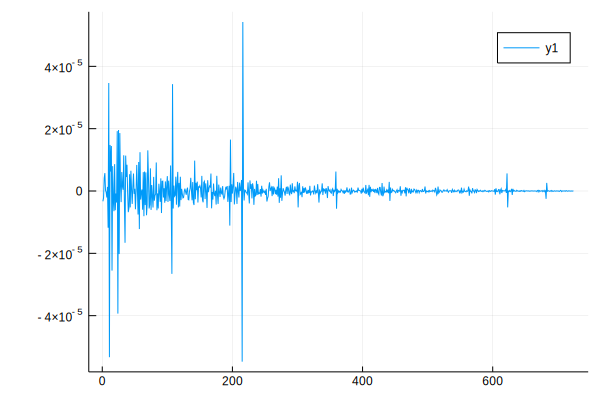

In [131]:
### Check stationarity of Nonrevolving consumer credit to Personal Income
plot(final[:PI])


In [34]:
### We will use this dataset in another notebook, "Dynamic Factor Model"
CSV.write("epic_matrix_quarterly.csv", final, writeheader = true)

"epic_matrix_quarterly.csv"

In [21]:
CSV.write("epic_matrix_monthly.csv", initial, writeheader = true)

"epic_matrix_monthly.csv"

In [35]:

#datra = CSV.read("epic_matrix.csv")


,date,Column2,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPL,RETAIL
,Date⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,1959-01-01,2437.3,0.00393351,0.00357626,0.0103497,missing,0.00730985
2,1959-02-01,2446.9,0.00643111,0.00737371,0.00939402,missing,0.0083212
3,1959-03-01,2462.69,0.00649814,0.00701939,-0.0035764,missing,0.000615712
4,1959-04-01,2478.74,0.00582628,0.00662948,0.0119843,missing,0.0078034
5,1959-05-01,2493.23,0.003108,0.00302211,0.00364585,missing,0.00906434
6,1959-06-01,2500.99,-0.00058554,-0.00080784,-0.00336493,missing,-0.000330178
7,1959-07-01,2499.53,-0.00569527,-0.00571601,0.0059929,missing,0.00636421
8,1959-08-01,2485.33,0.000788317,-4.27798e-5,0.0100012,missing,-0.013157
9,1959-09-01,2487.29,0.00122307,0.00119714,-0.00682331,missing,0.00728802
